# Cleaning bridges

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from shapely.geometry import Point


In [27]:
# Import the bridge data
df_brd_original = pd.read_excel('data/BMMS_overview.xlsx')
display(df_brd_original.head(5))

# Import the road data
df_rd = pd.read_csv('data/_roads_cleaned.tsv', sep='\t', low_memory=False)
display(df_rd.head(5))

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.8,19.5,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.4,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise
3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.30,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.88,12.2,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699833,90.530722,bcs1
4,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.30,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,12.2,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699667,90.530722,bcs1


,road,lrp1,lat1,lon1,lrp2,lat2,lon2,lrp3,lat3,lon3,...,lon1345,lrp1346,lat1346,lon1346,lrp1347,lat1347,lon1347,lrp1348,lat1348,lon1348
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961917,91.113611,LRP001a,23.967666,91.111889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.395250,LRP001,23.009306,91.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


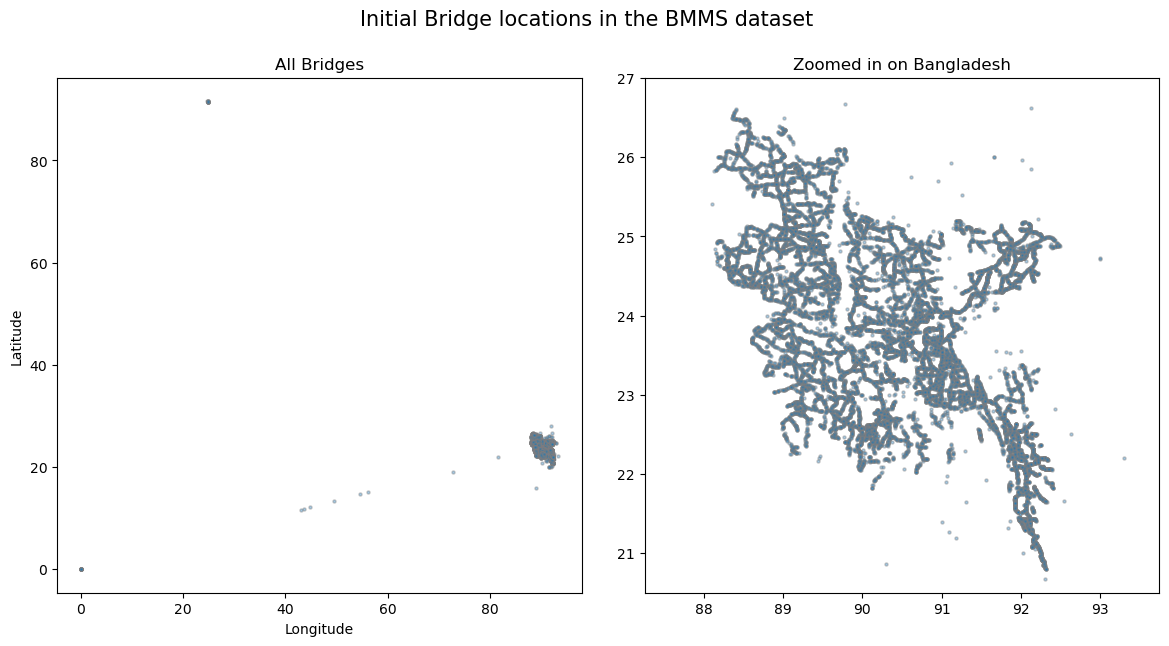

In [3]:
# Create plot function for the bridges
def plot_bridges(df):
    # Create a figure and axis
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Create a scatter plot for all the bridges
    ax[0].scatter(df['lon'], df['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4)

    # Create a scatter plot for the bridges, while zooming in on Bangladesh
    ax[1].scatter(df['lon'], df['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4)
    ax[1].set_xlim(88, 93)
    ax[1].set_ylim(20.5, 27)

    # Set the title and labels
    ax[0].set_title('All Bridges')
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[1].set_title('Zoomed in on Bangladesh')
    
    # Set the aspect of the plot to be equal
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[1].set_box_aspect(1)

    fig.suptitle('Initial Bridge locations in the BMMS dataset', fontsize=15, y=1.03)
    fig.tight_layout()
    plt.show()

# Plot the bridges
plot_bridges(df_brd_original)


### Step 1: Filter datapoints that are not located in bangladesh

In [4]:
import geopandas as gpd
gdf = gpd.read_file('data/shapefile_bangladesh')
gdf

,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,POP_EST,POP_RANK,GDP_MD_EST,POP_YEAR,...,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry
0,124,Admin-0 country,2,Sovereign country,People's Republic of Bangladesh,None,157826578,17,628400.0,2017,...,Bangladesh,Bangladeş,Bangladesh,孟加拉国,Bangladesh,None,SOA,53.187135,12.136245,"MULTIPOLYGON (((92.57588 21.97757, 92.59024 21..."


I use a buffer, as the shapefile is not that precise

C:\Users\groen\AppData\Local\Temp\ipykernel_27612\44470488.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bridges_outside = gdf_bridges[~gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]
C:\Users\groen\AppData\Local\Temp\ipykernel_27612\44470488.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bridges_inside = gdf_bridges[gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]


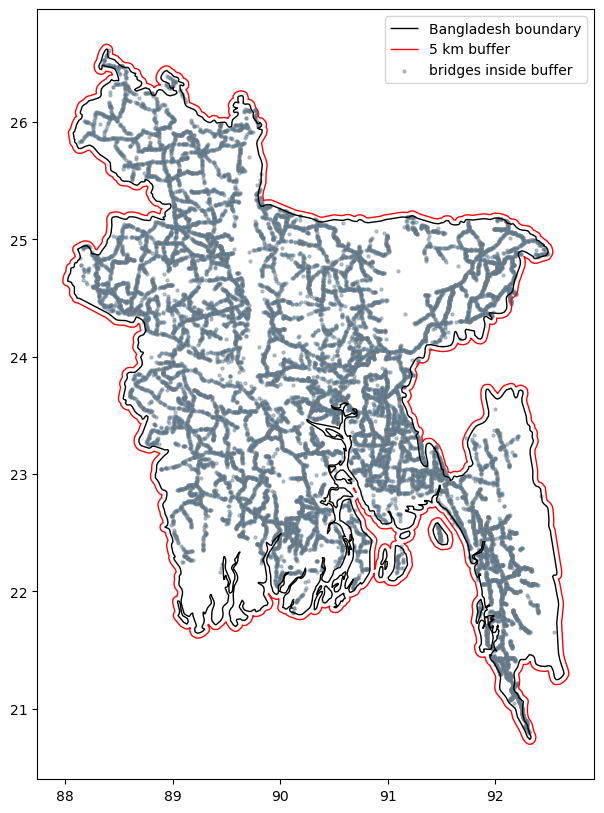

In [5]:
from shapely.geometry import Point

# Load the shapefile of Bangladesh
bangladesh_shape = gdf  # Update with actual file path

# Create a buffer of 5 km (5000 meters) around the Bangladesh boundary
bangladesh_buffered = bangladesh_shape.to_crs(epsg=3857).buffer(5000).to_crs(epsg=4326)

# Convert bridge locations into a GeoDataFrame
df_bridges = df_brd_original
geometry = [Point(lon, lat) for lon, lat in zip(df_bridges["lon"], df_bridges["lat"])]
gdf_bridges = gpd.GeoDataFrame(df_bridges, geometry=geometry, crs="EPSG:4326")

# Filter bridges that are **outside** the buffered area
bridges_outside = gdf_bridges[~gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]
bridges_inside = gdf_bridges[gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]

# Display the bridges in 5 km buffer zone of Bangladesh
fig, ax = plt.subplots(figsize=(10, 10))
bangladesh_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=1, label='Bangladesh boundary')
bangladesh_buffered.boundary.plot(ax=ax, edgecolor='red', linewidth=1, label='5 km buffer')
bridges_inside.plot(ax=ax, edgecolor='grey', facecolor=None, alpha=0.4, markersize=5, label='bridges inside buffer')
ax.legend()
plt.show()


We now have a dataframe with all bridges that are not located in bangladesh

In [6]:
# # Check if lat lon coordinates are changed

# def check_lat_lon(df, shapefile):
#     # Check if the latitude and longitude columns are within the expected range
#     for _, row in df.iterrows():
#         if row['lat'] < 21 or row['lat'] > 26 and row['lon'] < 88 or row['lon'] > 93:

#             # Change the lon and lat values of this row, changed, are in the shapefile
#             point = Point(row['lat'], row['lon'])
#             if point.within(shapefile.unary_union):
#                 print("Changed coordinates show location in bangladesh")
#     return


# check_lat_lon(bridges_outside.copy(), bangladesh_buffered)


In [7]:
def check_and_update_lat_lon(df, gdf_bridges, shapefile):
    bridges_to_remove = set()

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        if not (21 <= row['lat'] <= 26 and 88 <= row['lon'] <= 93):
            point = Point(row['lat'], row['lon'])
            if point.within(shapefile.unary_union):
                bridges_to_remove.add(row['name'])  # Use a set for fast lookups

    # Remove bridges directly in df
    df_cleaned = df[~df['name'].isin(bridges_to_remove)].copy()

    # Update lat/lon for bridges with swapped lat lon in gdf_bridges
    mask = gdf_bridges['name'].isin(bridges_to_remove)
    gdf_bridges.loc[mask, ['lat', 'lon']] = gdf_bridges.loc[mask, ['lon', 'lat']].values

    return df_cleaned, bridges_to_remove

# Call the function and remove bridges
updated_bridges_outside, bridges_lat_lon_swap = check_and_update_lat_lon(bridges_outside.copy(), gdf_bridges, bangladesh_buffered)

print(f"Removed bridges: {bridges_lat_lon_swap}")


C:\Users\groen\AppData\Local\Temp\ipykernel_27612\2937439458.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if point.within(shapefile.unary_union):


Removed bridges: {'MAJIDPUR TRUSS BRIDGE', 'KOKAL BOX CULVERT', 'GONGUR BAILEY WITH STEEL DECK', 'MAJIDEPUR BOX CULVERT', 'HIJLA BOX CULVERT', 'KHASIRA BAILEY WITH STEEL DECK', 'KHASIRA BOX CULVERT', 'COUNDER NOLA BOX CULVERT', 'EKOR CHAI BOX CULVERT', 'COUNDER NOLA BRIDGE', 'BOMBOMI BRIDGE', 'EKOR CHOL BOX CULVERT', 'KOLKALI BOX CULVERT', 'TARAKHAI BOX CULVERT', 'TARA KHAI BRIDGE'}


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


There were 15 bridges with swapped lat-lon coordinates


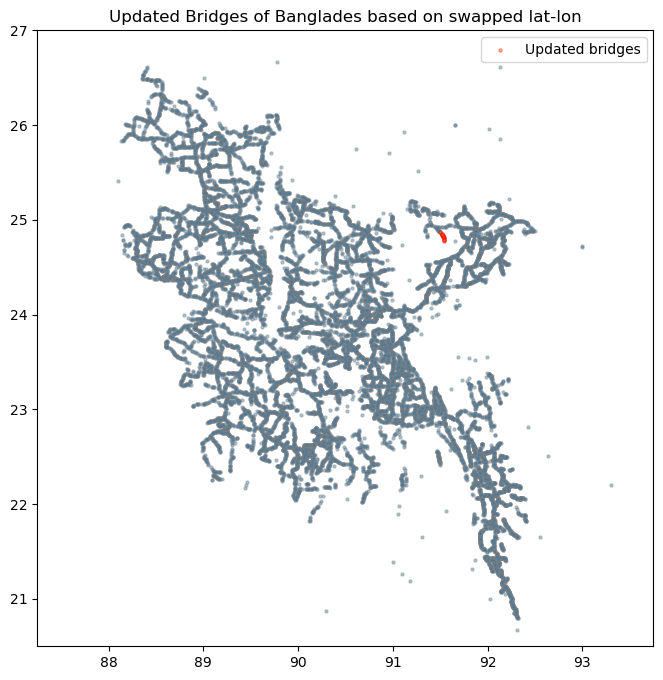

In [8]:
# Create plot to display the new bridges located in Bangladesh

def plot_bridges_in_bangladesh(df, df_to_highlight, title):
    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Create a scatter plot for all the bridges around Bangladesh
    ax.scatter(df['lon'], df['lat'], s=5, edgecolor='grey', facecolor=None, alpha=0.4)

    # Create a scatter plot for the updated bridges
    ax.scatter(df_to_highlight['lon'], df_to_highlight['lat'], s=5, edgecolor='red', facecolor=None, alpha=0.4, label='Updated bridges')

    # Set the title, labels, limits and legends
    ax.set_xlim(88, 93)
    ax.set_ylim(20.5, 27)
    ax.set_aspect('equal')
    ax.set_box_aspect(1)
    ax.set_title(title)
    ax.legend()

    plt.show()

# Plot the shapefile of Bangladesh
removed_bridges_df = gdf_bridges[gdf_bridges['name'].isin(bridges_lat_lon_swap)]
print(f'There were {len(removed_bridges_df)} bridges with swapped lat-lon coordinates')

plot_bridges_in_bangladesh(df_bridges, removed_bridges_df, title='Updated Bridges of Banglades based on swapped lat-lon')

## Link bridges to LRP names

Check if the LRPName and road of the bridges match with the LRPName and road of the road dataset

In [9]:
# Open the latest road data
df_rd = pd.read_csv('data/_roads.tsv', sep='\t', low_memory=False) # Update with actual file path
df_rd.head()

,road,lrp1,lat1,lon1,lrp2,lat2,lon2,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 4035,Unnamed: 4036,Unnamed: 4037,Unnamed: 4038,Unnamed: 4039,Unnamed: 4040,Unnamed: 4041,Unnamed: 4042,Unnamed: 4043,Unnamed: 4044
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961917,91.113611,LRP001a,23.967666,91.111889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.395250,LRP001,23.009306,91.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
gdf_bridges.head()

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,geometry
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.8,...,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1,POINT (90.45039 23.70289)
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,...,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1,POINT (90.47883 23.69361)
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,...,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise,POINT (90.51883 23.70458)
3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.30,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.88,...,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699833,90.530722,bcs1,POINT (90.53072 23.69983)
4,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.30,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,...,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699667,90.530722,bcs1,POINT (90.53072 23.69967)


In [11]:
# Check if the LRPName and road of the bridges match with the LRPName and road of the road dataset

def check_bridge_road_match(df_bridges, df_rd):
    # Create a set to store the bridges that do not match
    bridges_not_matching = set()

    # Iterate through each row in the DataFrame
    for _, row in df_bridges.iterrows():
        # Check if the bridge's LRPName and road are not in the road dataset
        if row['road'] not in df_rd['road'].values: # or row['LRPName'] not in df_rd['LRPName'].values:
            bridges_not_matching.add(row['structureNr'])

    return bridges_not_matching

# Call the function to check for bridges that do not match
bridges_not_matching = check_bridge_road_match(gdf_bridges.copy(), df_rd.copy())

print(bridges_not_matching)
print(len(bridges_not_matching))

{118791, 118793, 118795, 118798, 120878, 120879, 118833, 118834, 120883, 116832, 116833, 116834, 116835, 116836, 118959, 118961, 118963, 121016, 121019, 121023, 118981, 118983, 118986, 118987, 118989, 118990, 118992, 116064, 119052, 117047, 117048, 117049, 117050, 117051, 117053, 117054, 117055, 117056, 118113, 115061, 115063, 115064, 115065, 120157, 115076, 115078, 102264, 102266, 102270, 113154, 113155, 113159, 113160, 113161, 113162, 113166, 113167, 113170, 113171, 113173, 113174, 113176, 113177, 100944, 113245, 113248, 113251, 119396, 121445, 113253, 121444, 121446, 113257, 121449, 121451, 113261, 121454, 113273, 119418, 113274, 113278, 113279, 113283, 113284, 121480, 113289, 113290, 113293, 113296, 113297, 113298, 113301, 113303, 113307, 113308, 113312, 113313, 113315, 113318, 113321, 113324, 105135, 105137, 105147, 105151, 115429, 115430, 115432, 115433, 115434, 119555, 103222, 103234, 117571, 117572, 117573, 117574, 117575, 117576, 117577, 117578, 117579, 117580, 117581, 117582,

## Create a plot for a single road with all bridges on that road

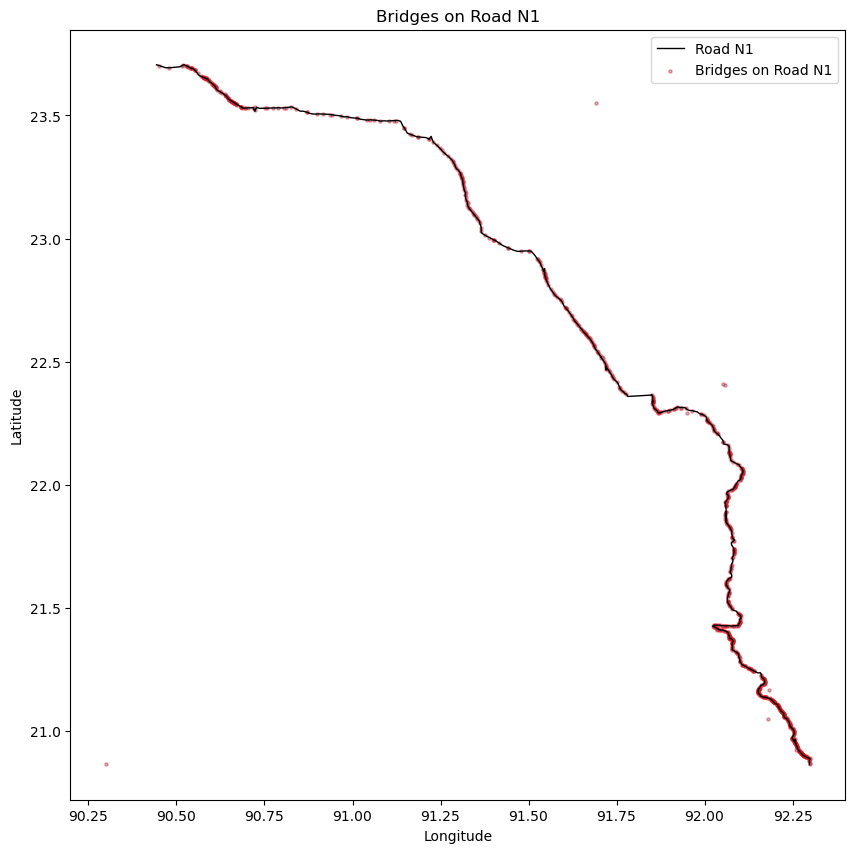

,road,chainage,lrp,lat,lon,type,name
0,N1,0.000,LRPS,23.706028,90.443333,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,KmPost,Km post missing


In [29]:
road = 'N1'

specific_road_index = df_rd[df_rd['road'] == road].index[0]
specific_road = df_rd.iloc[specific_road_index]

# Select every third value for 'LAT' and every third +1 value for 'LON'
df_rd_N1 = pd.DataFrame({
    'LRP': specific_road.iloc[1::3].values,   # Every third value
    'LAT': specific_road.iloc[2::3].values,   # Every third value
    'LON': specific_road.iloc[3::3].values   # Every third +1 value
})

df_rd_N1['LAT'] = df_rd_N1['LAT'].astype(float)
df_rd_N1['LON'] = df_rd_N1['LON'].astype(float)

df_rd_N1

# Bridges on the specific road
bridges_on_road = gdf_bridges[gdf_bridges['road'] == road]

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road
ax.plot(df_rd_N1['LON'], df_rd_N1['LAT'], color='black', linewidth=1, label='Road N1')

# plot the bridges
ax.scatter(bridges_on_road['lon'], bridges_on_road['lat'], s=5, edgecolor='red', facecolor=None, alpha=0.4, label='Bridges on Road N1')

# Set the title, labels and legend
ax.set_title('Bridges on Road N1')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

drainage_df = pd.read_csv('data/Roads_InfoAboutEachLRP.csv', sep=',', low_memory=False)
display(drainage_df.head(5))

## Check for change in min / sec 

### Correct bridges that aren't on the correct road location

In [ ]:
import numpy as np
import pandas as pd

# Load the road data with chainage information
df_road_chainage = pd.read_csv('data/Roads_InfoAboutEachLRP.csv', sep=',', low_memory=False)
df_roads_cleaned = pd.read_csv('data/_roads_cleaned.tsv', sep='\t', low_memory=False)

# Merge the road chainage data
df_roads_cleaned_chainage = pd.merge(df_roads_cleaned, df_road_chainage, on='road', how='left')

# Ensure correct lat/lon column names
if 'lat' not in df_roads_cleaned_chainage.columns:
    df_roads_cleaned_chainage.rename(columns={'lat1': 'lat', 'lon1': 'lon'}, inplace=True)

# Function to find the road points before and after the bridge
def find_road_points(df, chainage):
    before = df[df['chainage'] <= chainage].sort_values('chainage', ascending=False)
    after = df[df['chainage'] >= chainage].sort_values('chainage', ascending=True)
    
    if before.empty or after.empty:
        return None, None  # Handle missing cases
    
    return before.iloc[0], after.iloc[0]  # Closest before/after points

# Function to update bridge coordinates if necessary
def update_bridge_coordinates(df_bridges, df_road):
    for idx, bridge in df_bridges.iterrows():
        road_points = df_road[df_road['road'] == bridge['road']]
        
        if not road_points.empty:
            before, after = find_road_points(road_points, bridge['chainage'])
            if before is None or after is None:
                continue  # Skip if no valid points found
            
            # Skip adjustment if the bridge is already within the correct range
            if before['chainage'] <= bridge['chainage'] <= after['chainage']:
                continue 

            # Compute segment length
            segment_dist = np.sqrt((before['lat'] - after['lat'])**2 + (before['lon'] - after['lon'])**2)
            threshold = max(1.5 * segment_dist, 0.001)  # Ensure reasonable threshold
            
            # Compute distances to the bridge
            distance_before = np.sqrt((before['lat'] - bridge['lat'])**2 + (before['lon'] - bridge['lon'])**2)
            distance_after = np.sqrt((after['lat'] - bridge['lat'])**2 + (after['lon'] - bridge['lon'])**2)
            
            # If bridge is too far, reposition it
            if distance_before > threshold or distance_after > threshold:
                df_bridges.at[idx, 'lat'] = (before['lat'] + after['lat']) / 2
                df_bridges.at[idx, 'lon'] = (before['lon'] + after['lon']) / 2

    return df_bridges

# Update the bridge coordinates
updated_bridges_chainage = update_bridge_coordinates(gdf_bridges.copy(), df_roads_cleaned_chainage.copy())

# Display results
updated_bridges_chainage.head()